In [8]:
import pandas as pd
import torch

# Load the contents of function_smell_embeddings.pt
old_embed = torch.load('./bert_old2.pt')
fix_embed = torch.load('./bert_fixed2.pt')
smell_key = pd.read_csv("Temp_smellKey-data_encoded.csv")["smellKey_encoded"]
smell_key

0     0
1     0
2     0
3     0
4     0
     ..
88    2
89    3
90    2
91    3
92    1
Name: smellKey_encoded, Length: 93, dtype: int64

# Import

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

In [17]:
# Load embeddings (assuming they are already loaded)
df = pd.read_csv('Temp_smellKey-data_encoded.csv')
df_smell = pd.read_csv("Temp_smellKey-data_encoded.csv")
embeddings = torch.load('bert_old.pt')
embeddings2 = torch.load('bert_fixed.pt')
labels = df_smell['smellKey_encoded'].values
print(labels)
print(embeddings.shape, embeddings2.shape, labels.shape)
# Combine embeddings into pairs
df

[0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 2
 1 2 2 2 2 2 2 2 1 1 2 2 2 4 2 1 2 3 1 1 2 3 3 3 2 1 1 2 2 2 1 2 2 2 2 1 3
 3 2 3 2 2 2 2 2 2 2 2 2 2 3 2 3 2 3 1]
torch.Size([140, 768]) torch.Size([140, 768]) (93,)


,old_code,fixed_code,SmellRule,smellKey_encoded
0,"{""function"": ""public boolean doSave(Carrello b...","{""function"": ""public boolean doSave(Carrello b...",java:S106\n,0
1,"{""function"": ""protected void doPost(HttpServle...","{""function"": ""protected void doPost(HttpServle...",java:S106\n,0
2,"{""function"": ""public static synchronized void ...","{""function"": ""public static synchronized void ...",java:S106\n,0
3,"{""function"": ""public static synchronized void ...","{""function"": ""public static synchronized void ...",java:S106\n,0
4,"{""function"": ""public static synchronized byte[...","{""function"": ""public static synchronized byte[...",java:S106\n,0
...,...,...,...,...
88,"{""function"": ""public Object deserialize(JsonPa...","{""function"": ""public Object deserialize(JsonPa...",java:S3740\n,2
89,"{""function"": "" CodeEmitter<T> emit(final Strin...","{""function"": "" CodeEmitter<T> emit(final Strin...",java:S3776\n,3
90,"{""function"": ""public Expression createExpressi...","{""function"": ""public Expression createExpressi...",java:S3740\n,2
91,"{""function"": ""public ConfigurationPropertiesVa...","{""function"": ""public ConfigurationPropertiesVa...",java:S3776\n,3


In [25]:
import torch
from sklearn.model_selection import train_test_split

# Assuming old_embed and fix_embed are lists of embeddings
old_embed = df['old_code'].tolist()
fix_embed = df['fixed_code'].tolist()

# Convert lists of embeddings to PyTorch tensors
old_embed_tensor = torch.tensor(embeddings)
fix_embed_tensor = torch.tensor(embeddings2)

# Stack the tensors along the specified dimension
X = torch.stack((old_embed_tensor, fix_embed_tensor), dim=1)

# Convert X tensor to NumPy array
X = X.numpy()
print("Length of X:", len(X))
print("Length of labels:", len(labels))

# Ensure labels match the length of X
labels = df_smell['smellKey_encoded'].values[:len(X)]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Convert the split data back to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)

print("X_train shape:", X_train_tensor.shape)
print("X_test shape:", X_test_tensor.shape)


Length of X: 140
Length of labels: 93


C:\Users\huday\AppData\Local\Temp\ipykernel_1356\907931140.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  old_embed_tensor = torch.tensor(embeddings)
C:\Users\huday\AppData\Local\Temp\ipykernel_1356\907931140.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fix_embed_tensor = torch.tensor(embeddings2)


ValueError: Found input variables with inconsistent numbers of samples: [140, 93]

# Model

In [27]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# Define the model parameters
input_dim = X_train_tensor.shape[2]
hidden_dim = 128
output_dim = len(np.unique(y))

print(input_dim, hidden_dim, output_dim)

# Create the LSTM model
model = LSTMModel(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader objects
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Define empty lists to store evaluation metrics
train_accuracy_list = []
val_accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

768 128 5


# Train

In [30]:
# Training the LSTM model
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        #print(outputs.shape)
        #print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    # Evaluate the LSTM model
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train_tensor.float())
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_accuracy = (train_predicted == y_train_tensor).sum().item() / len(y_train_tensor)

        val_outputs = model(X_test_tensor.float())
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_accuracy = (val_predicted == y_test_tensor).sum().item() / len(y_test_tensor)

        train_precision = precision_score(y_train_tensor, train_predicted, average='weighted', zero_division=1)
        val_precision = precision_score(y_test_tensor, val_predicted, average='weighted', zero_division=1)

        train_recall = recall_score(y_train_tensor, train_predicted, average='weighted')
        val_recall = recall_score(y_test_tensor, val_predicted, average='weighted')

        train_f1 = f1_score(y_train_tensor, train_predicted, average='weighted', zero_division=1)
        val_f1 = f1_score(y_test_tensor, val_predicted, average='weighted', zero_division=1)

        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
        recall_list.append(val_recall)
        f1_list.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: , "
              f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {val_accuracy:.4f}")


Epoch 1/10, Train Loss: , Train Accuracy: 0.7838, Test Accuracy: 0.5263
Epoch 2/10, Train Loss: , Train Accuracy: 0.8108, Test Accuracy: 0.5263
Epoch 3/10, Train Loss: , Train Accuracy: 0.8514, Test Accuracy: 0.5263
Epoch 4/10, Train Loss: , Train Accuracy: 0.8649, Test Accuracy: 0.5263
Epoch 5/10, Train Loss: , Train Accuracy: 0.8784, Test Accuracy: 0.5263
Epoch 6/10, Train Loss: , Train Accuracy: 0.8919, Test Accuracy: 0.5263
Epoch 7/10, Train Loss: , Train Accuracy: 0.8919, Test Accuracy: 0.5263
Epoch 8/10, Train Loss: , Train Accuracy: 0.9054, Test Accuracy: 0.5263
Epoch 9/10, Train Loss: , Train Accuracy: 0.9054, Test Accuracy: 0.4737
Epoch 10/10, Train Loss: , Train Accuracy: 0.9054, Test Accuracy: 0.4737


30


ValueError: x and y must have same first dimension, but have shapes (10,) and (30,)

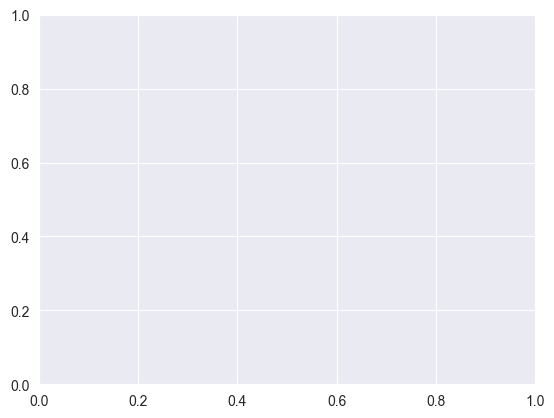

In [31]:
# Plot the accuracy over epochs for training and validation
print(len(val_accuracy_list))
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_list, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


# Plot precision, recall, and F1-score over epochs for validation
plt.plot(range(1, num_epochs + 1), precision_list, label='Precision')
plt.plot(range(1, num_epochs + 1), recall_list, label='Recall')
plt.plot(range(1, num_epochs + 1), f1_list, label='F1-score')
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Metrics over Epochs (Test)")
plt.legend()
plt.show()